# Imports

In [ ]:
!pip install numpy==2.0.2 -q
!pip install pandas==2.2.2 -q
!pip install torch==2.7.0 -q
!pip install torchvision==0.22.0 -q
!pip install scikit-learn==1.6.1 -q
!pip install spacy==3.8.5 -q
!pip install transformers==4.51.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/balanced_2verbs_dataset/train.json.zip" -d "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/balanced_2verbs_dataset"
# !unzip "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/balanced_2verbs_dataset/test.json.zip" -d "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/balanced_2verbs_dataset"

In [ ]:
import itertools
import json
import math
import re

from pathlib import Path

import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from spacy.lang.ru import Russian
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
# !pip freeze

# Tokenization with Morpheme Segmentation

In [ ]:
model_name = "CrabInHoney/morphbert-large-morpheme-segmentation-ru"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)
model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/307 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/342M [00:00<?, ?B/s]

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(75, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
def analyze(word):
  tokens = list(word)
  encoded = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True, max_length=34).to("cuda")
  with torch.no_grad():
      logits = model(**encoded).logits
      predictions = logits.argmax(dim=-1)[0]

  word_ids = encoded.word_ids()
  output = []
  current_label = None
  current_chunk = []

  for i, word_idx in enumerate(word_ids):
    if word_idx is not None and word_idx < len(tokens):
      label_id = predictions[i].item()
      label = model.config.id2label[label_id]
      token = tokens[word_idx]
      if label == current_label:
          current_chunk.append(token)
      else:
          if current_chunk:
              chunk_str = "".join(current_chunk)
              output.append(f"{chunk_str}")
          current_chunk = [token]
          current_label = label

  if current_chunk:
    chunk_str = "".join(current_chunk)
    output.append(f"{chunk_str}")

    return output

In [ ]:
labels = set(model.config.id2label.values())
text = "«Фобос-Грунт» — российская автоматическая межпланетная станция (АМС), которую пилотировал Денис 3 минуты."
nlp = Russian()
doc = nlp(text)
tokens = [token.text for token in doc]
print(analyze(tokens[6]))

['росс', 'ий', 'ск', 'ая']


In [ ]:
def segment_morphemes(token):
  token_sequence = []
  characters = []
  word_re = re.compile(r'#?(_-|[а-яА-ЯйЙёЁa-zA-Z])+')

  # ловим регуляркой слово (включая дефисы) на латинице или кириллице
  word = word_re.search(token)
  if word and word[0] == token and token not in ('-', '[CLS]'):
    сhars_marked = analyze(token)
    token_sequence.extend(сhars_marked)
  else:
    token_sequence.append(token)
  return token_sequence

In [ ]:
train_p = Path("/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/train.json")
test_p = Path("/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/test.json")


train = pd.read_json(train_p, orient='records')
y_train = train['вид_совершенный']

test = pd.read_json(test_p, orient='records')
y_test = test['вид_совершенный']

X_train = train.drop(columns=['вид_совершенный'])
X_test = test.drop(columns=['вид_совершенный'])

In [ ]:
nlp = Russian()

X_train['контекст'] = X_train['контекст'].apply(nlp)
X_train['контекст'] = X_train['контекст'].apply(lambda row: ['[CLS]'] + [token.text.lower() for token in row])

X_test['контекст'] = X_test['контекст'].apply(nlp)
X_test['контекст'] = X_test['контекст'].apply(lambda row: ['[CLS]'] + [token.text.lower() for token in row])

In [ ]:
train_contexts =  []

def merge_contexts(context):
  train_contexts.extend(context)
  return train_contexts

X_train['контекст'].apply(lambda x: train_contexts.extend(x))
n_wordforms = len(train_contexts)
print(train_contexts, n_wordforms)
train_contexts = set(train_contexts)

word_morph_an = {}
def perform_an(word):
  if word not in word_morph_an:
    word_morph_an[word] = segment_morphemes(word)
    return word_morph_an

train_contexts = pd.Series(list(train_contexts))
train_contexts = train_contexts.apply(perform_an)

['[CLS]', 'я', '-', 'то', 'сама', 'не', 'помню', ',', 'люди', 'рассказывают', '.', 'деревня', ',', 'говорят', ',', 'была', 'большая', ',', 'землю', 'арендовали', '»', '.', 'у', 'тех', ',', 'кто', 'жил', 'в', 'этой', 'усадьбе', '?', '»', '[CLS]', 'эвакуировалась', 'школа', ',', 'в', 'которой', 'работала', 'катерина', 'ильинична', '.', '[CLS]', 'позвольте', 'вам', 'рекомендовать', 'себя', ',', '—', 'сказала', 'она', 'мне', 'с', 'самою', 'тончайшею', 'светскою', 'вежливостью', '.', '[CLS]', 'для', 'увеличения', 'интенсивности', 'люминесценции', 'получаемых', 'структур', 'дополнительно', 'имплантируются', 'ионы', 'кислорода', 'с', 'энергиями', '0,28', 'и', '0,22', 'мэв', 'и', 'дозой', '1', '-', '10', '15', 'см', '"', '2', '.', '[CLS]', 'в', 'известном', 'отношении', ',', 'она', 'оплодотворяет', 'жизнь', ',', 'интенсифицирует', ',', 'красит', 'ее', '.', '[CLS]', 'хорошо', ',', 'конечно', ',', 'что', 'я', 'сбросил', 'с', 'себя', 'груз', 'привязанностей', 'и', 'т.д.', ';', 'но', 'было', 'немн

In [ ]:
morp_toks = tuple(itertools.chain(*word_morph_an.values()))
unique_tokens_train = tuple(set(morp_toks))

print(f'''Кол-во словоформ-токенов + пунктуация: {n_wordforms}
Кол-во уникальных словоформ-токенов + пунктуация: {len(word_morph_an)}
Кол-во морфем-токенов + пунктуация: {len(morp_toks)}
Кол-во уникальных морфем-токенов + пунктуация: {len(unique_tokens_train)}''')

Кол-во словоформ-токенов + пунктуация: 866277
Кол-во уникальных словоформ-токенов + пунктуация: 114782
Кол-во морфем-токенов + пунктуация: 370322
Кол-во уникальных морфем-токенов + пунктуация: 33535


In [ ]:
X_train['контекст'].head()

0    [[CLS], я, -, то, сама, не, помню, ,, люди, ра...
1    [[CLS], эвакуировалась, школа, ,, в, которой, ...
2    [[CLS], позвольте, вам, рекомендовать, себя, ,...
3    [[CLS], для, увеличения, интенсивности, люмине...
4    [[CLS], в, известном, отношении, ,, она, оплод...
Name: контекст, dtype: object

In [ ]:
_ = {k: word_morph_an[k].append('[SEP]') for k in word_morph_an if word_morph_an[k][-1].isalnum()}
word_morph_an

X_train['контекст'] = X_train['контекст'].apply(lambda row: [word_morph_an[tok] for tok in row])
X_train['контекст'] = X_train['контекст'].apply(lambda row: list(itertools.chain(*row)))

In [ ]:
def gen_token_indices(vocab):
    indices = {tok: inx for inx, tok in enumerate(vocab, start=5)}
    return indices

tok2inx = gen_token_indices(unique_tokens_train)
tok2inx.update({
    '[PAD]': 0,
    '[UNK]': 1,
    '[CLS]': 2,
    '[SEP]': 3,
    '[MASK]': 4
})
print(len(tok2inx))
inx2tok = {int(v): k for k, v in tok2inx.items()}

X_train['контекст_bert'] = X_train['контекст'].apply(lambda x: [tok2inx.get(tok) for tok in x])

33539


In [ ]:
print(X_train['контекст_bert'].isna().sum())
X_train['контекст_bert'].head()

0


0    [2, 27704, 3, 11570, 30273, 17325, 3, 14257, 9...
1    [2, 26671, 25700, 9059, 10370, 24674, 3, 28762...
2    [2, 5736, 24773, 3, 22653, 3, 31731, 9059, 139...
3    [2, 10891, 27704, 3, 4180, 20583, 32007, 27704...
4    [2, 8340, 3, 12944, 28066, 3, 22903, 18470, 32...
Name: контекст_bert, dtype: object

In [ ]:
test_contexts = []

X_test['контекст'].apply(lambda x: test_contexts.extend(x))
test_contexts = set(test_contexts)

test_contexts = pd.Series(list(test_contexts))
test_contexts = test_contexts.apply(perform_an)
print(type(test_contexts), len(test_contexts))

<class 'pandas.core.series.Series'> 67632


In [ ]:
X_test['контекст'].head()

0    [[CLS], в, 1982-м, году, в, сша, эмигрировал, ...
1    [[CLS], тула, эвакуировалась, ,, но, разве, вс...
2    [[CLS], как, видно, из, рисунка, ,, элитная, г...
3    [[CLS], она, продавала, мебель, фирме, «, баст...
4    [[CLS], и, вовсе, нет, приевшейся, стилизации,...
Name: контекст, dtype: object

Здесь видим явную экономию от морфемного энкодинга. А ещё будет интерпретируемость, в отличии от bpe.

In [ ]:
# Сравним кол-во уникальных морфем на датасет и кол-во уникальных слов (также в обоих датасетах пунктуационные символы)
unique_tokens = set(itertools.chain(*word_morph_an.values()))

sum_morphemes = len(unique_tokens)
sum_wordforms = len(word_morph_an.keys())
print(sum_morphemes, sum_wordforms)

40380 142618


In [ ]:
X_train.head()

лемма       словоформа  \
0         арендовать       арендовали   
1     эвакуироваться   Эвакуировалась   
2      рекомендовать    рекомендовать   
3     имплантировать   имплантируются   
4  интенсифицировать  интенсифицирует   

                                            контекст  \
0  [[CLS], я, [SEP], -, т, о, [SEP], сам, а, [SEP...   
1  [[CLS], эваку, ир, ова, ла, сь, [SEP], школ, а...   
2  [[CLS], позволь, те, [SEP], вам, [SEP], рекоме...   
3  [[CLS], дл, я, [SEP], у, велич, ени, я, [SEP],...   
4  [[CLS], в, [SEP], извест, ном, [SEP], от, нош,...   

                        грамматика_pm  \
0       VERB,impf,past,indc,plur,tran   
1  VERB,impf,past,femn,indc,sing,intr   
2                      INFN,impf,tran   
3  VERB,impf,pres,indc,plur,3per,intr   
4  VERB,impf,pres,indc,sing,3per,tran   

                                       контекст_bert  
0  [2, 27704, 3, 11570, 30273, 17325, 3, 14257, 9...  
1  [2, 26671, 25700, 9059, 10370, 24674, 3, 28762...  
2  [2, 5736, 24773, 3, 22653, 3, 31731, 9059, 139...  
3  [2, 10891, 27704, 3, 4180, 20583, 32007, 27704...  
4  [2, 8340, 3, 12944, 28066, 3, 22903, 18470, 32...

In [ ]:
X_test['контекст'] = X_test['контекст'].apply(lambda row: [word_morph_an[tok] for tok in row])
X_test['контекст'] = X_test['контекст'].apply(lambda row: list(itertools.chain(*row)))

# inx of '[UNK]' token = 1
X_test['контекст_bert'] = X_test['контекст'].apply(lambda x: [tok2inx.get(tok, 1) for tok in x])

In [ ]:
X_test.head()

лемма      словоформа  \
0    эмигрировать     эмигрировал   
1  эвакуироваться  эвакуировалась   
2   деградировать     деградирует   
3      арендовать      арендовали   
4    симулировать    симулировать   

                                            контекст  \
0  [[CLS], в, [SEP], 1982-м, год, у, [SEP], в, [S...   
1  [[CLS], тул, а, эваку, ир, ова, ла, сь, [SEP],...   
2  [[CLS], как, [SEP], видн, о, [SEP], из, [SEP],...   
3  [[CLS], он, а, [SEP], прода, ва, л, а, [SEP], ...   
4  [[CLS], и, [SEP], в, о, вс, е, [SEP], нет, [SE...   

                        грамматика_pm  \
0  VERB,perf,past,masc,indc,sing,intr   
1  VERB,perf,past,femn,indc,sing,intr   
2  VERB,impf,pres,indc,sing,3per,intr   
3       VERB,impf,past,indc,plur,tran   
4                      INFN,impf,tran   

                                       контекст_bert  
0  [2, 8340, 3, 1, 12133, 4180, 3, 8340, 3, 12569...  
1  [2, 22613, 9236, 26671, 25700, 9059, 10370, 24...  
2  [2, 7806, 3, 7922, 17325, 3, 29658, 3, 394, 25...  
3  [2, 23925, 9236, 3, 30297, 7568, 12914, 9236, ...  
4  [2, 19076, 3, 8340, 17325, 27271, 19319, 3, 80...

In [ ]:
train_lens = X_train['контекст_bert'].map(len)
train_lens.describe()

count    31745.000000
mean        77.221137
std         43.484179
min          3.000000
25%         47.000000
50%         68.000000
75%         97.000000
max        747.000000
Name: контекст_bert, dtype: float64

In [ ]:
test_lens = X_test['контекст_bert'].map(len)
test_lens.describe()

count    13605.000000
mean        75.102903
std         42.331241
min          5.000000
25%         46.000000
50%         67.000000
75%         93.000000
max        936.000000
Name: контекст_bert, dtype: float64

In [ ]:
X_train

лемма       словоформа  \
0             арендовать       арендовали   
1         эвакуироваться   Эвакуировалась   
2          рекомендовать    рекомендовать   
3         имплантировать   имплантируются   
4      интенсифицировать  интенсифицирует   
...                  ...              ...   
31740     экспортировать     экспортируют   
31741        форсировать       форсировал   
31742      акцентировать     акцентировал   
31743       финишировать     финишировала   
31744    визуализировать  визуализируется   

                                                контекст  \
0      [[CLS], я, [SEP], -, т, о, [SEP], сам, а, [SEP...   
1      [[CLS], эваку, ир, ова, ла, сь, [SEP], школ, а...   
2      [[CLS], позволь, те, [SEP], вам, [SEP], рекоме...   
3      [[CLS], дл, я, [SEP], у, велич, ени, я, [SEP],...   
4      [[CLS], в, [SEP], извест, ном, [SEP], от, нош,...   
...                                                  ...   
31740  [[CLS], суть, [SEP], депутат, ск, ой, [SEP], и...   
31741  [[CLS], когд, а, [SEP], вы, ясн, и, л, ос, ь, ...   
31742  [[CLS], в, [SEP], качеств, е, [SEP], обрат, н,...   
31743  [[CLS], из, [SEP], десят, и, [SEP], про, шед, ...   
31744  [[CLS], примити, вн, ая, [SEP], картин, а, [SE...   

                            грамматика_pm  \
0           VERB,impf,past,indc,plur,tran   
1      VERB,impf,past,femn,indc,sing,intr   
2                          INFN,impf,tran   
3      VERB,impf,pres,indc,plur,3per,intr   
4      VERB,impf,pres,indc,sing,3per,tran   
...                                   ...   
31740  VERB,impf,pres,indc,plur,3per,tran   
31741  VERB,perf,past,masc,indc,sing,tran   
31742  VERB,impf,past,masc,indc,sing,tran   
31743  VERB,impf,past,femn,indc,sing,intr   
31744  VERB,impf,pres,indc,sing,3per,intr   

                                           контекст_bert  
0      [2, 27704, 3, 11570, 30273, 17325, 3, 14257, 9...  
1      [2, 26671, 25700, 9059, 10370, 24674, 3, 28762...  
2      [2, 5736, 24773, 3, 22653, 3, 31731, 9059, 139...  
3      [2, 10891, 27704, 3, 4180, 20583, 32007, 27704...  
4      [2, 8340, 3, 12944, 28066, 3, 22903, 18470, 32...  
...                                                  ...  
31740  [2, 6126, 3, 4794, 16305, 539, 3, 26657, 12749...  
31741  [2, 3700, 9236, 3, 3426, 15349, 19076, 12914, ...  
31742  [2, 8340, 3, 19514, 19319, 3, 7961, 16590, 539...  
31743  [2, 29658, 3, 26216, 19076, 3, 23596, 5119, 30...  
31744  [2, 17238, 5744, 26787, 3, 25792, 9236, 3, 276...  

[31745 rows x 5 columns]

In [ ]:
path = Path('/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset')

X_train['контекст_bert'].to_json(path / 'bert_train.json', orient='records')
X_test['контекст_bert'].to_json(path / 'bert_test.json', orient='records')

with open(path / 'inx2tok.json', 'w', encoding='utf-8') as f:
  json.dump(inx2tok, f, ensure_ascii=False, indent=4)

# Params

In [ ]:
path = Path('/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset')

with open(path / 'inx2tok.json', 'r', encoding='utf-8') as f:
  inx2tok = json.load(f)
  inx2tok = {int(k): v for k, v in inx2tok.items()}

tok2inx = {v: int(k) for k, v in inx2tok.items()}
# 0 is '[PAD]' token index

X_train = pd.read_json(path / 'bert_train.json', orient='records').fillna(0)
X_test = pd.read_json(path / 'bert_test.json', orient='records').fillna(0)

train_p = path / 'train.json'
test_p = path / 'test.json'

y_train = pd.read_json(train_p, orient='records')['вид_совершенный'].apply(lambda x: 1 if x is True else 0)
y_test = pd.read_json(test_p, orient='records')['вид_совершенный'].apply(lambda x: 1 if x is True else 0)

In [ ]:
tokens2proc = list({
  'когда-нибудь', 'когда-либо',
  'день', 'вечер', 'час', 'месяц', 'год', 'раз', 'квартал', 'семестр', 'триместр', 'век',
  'неделя', 'минута', 'секунда', 'осень', 'зима', 'весна', 'ночь', 'четверть', 'декада',
  'неделю', 'минуту', 'секунду', 'зиму', 'весну',
  'утро', 'лето', 'воскресенье', 'полугодие', 'десятилетие', 'столетие', 'тысячелетие',
  'сутки',
  'понедельникам', 'вторникам', 'средам', 'четвергам', 'пятницам', 'субботам', 'воскресеньям',
  'утрам', 'вечерам', 'ночам', 'январям', 'февралям', 'мартам', 'апрелям', 'маям', 'июням',
  'июлям', 'августам', 'сентябрям', 'октябрям', 'ноябрям', 'декабрям',
  'каждым',
  'полминуты', 'полдень', 'полмесяца', 'полгода', 'полсекунды', 'полчаса',
  'будете', 'буду', 'будет', 'будем', 'будут', 'будешь',
  'начать', 'начинать', 'стать', 'продолжить', 'nродолжать', 'кончить', 'кончать',
  'бросить', 'бросать', 'закончить', 'заканчивать', 'окончить', 'оканчивать', 'покончить',
  'стартовать', 'пуститься', 'пускаться', 'перестать', 'переставать', 'прекратить', 'прекращать',
  'надо', 'нужно', 'стоить', 'следовать', 'подобать', 'надобно', 'рекомендуется',
  'вредно', 'больно', 'грустно', 'бесполезно', 'скучно', 'невыносимо', 'плохо', 'тоскливо',
  'противно', 'неинтересно', 'неприятно', 'опасно', 'упорно', 'настойчиво',
  'советовать', 'посоветовать', 'просить', 'попросить', 'предлагать', 'предложить',
  'рекомендовать', 'порекомендовать', 'обещать', 'пообещать', 'договориться', 'договариваться',
  'решить', 'решать', 'постановить', 'постановлять', 'обязаться', 'обязываться', 'клясться',
  'поклясться', 'убеждать', 'убедить', 'призывать', 'призвать', 'разрешать', 'разрешить',
  'уговорить', 'уговаривать', 'приказать', 'приказывать', 'упросить', 'упрашивать', 'велеть',
  'потребовать', 'требовать', 'распорядиться', 'распоряжаться',
  'манера', 'привычка',
  'стремление', 'умение', 'желание', 'способность', 'готовность', 'попытка', 'мечта', 'грёзы',
  'старание', 'навык', 'страсть', 'совет', 'просьба', 'предложение', 'рекомендация', 'обещание',
  'договор', 'решение', 'постановление', 'обязательство', 'клятва', 'убеждение', 'призыв',
  'разрешение', 'уговор', 'приказ', 'упрашивание', 'веление', 'требование', 'распоряжение',
  'зачем',
  'хватит', 'довольно', 'надоело', 'запрещено', 'противопоказано',
  'разонравиться', 'наскучить', 'наскучивать', 'надоесть', 'научить', 'надоедать', 'устать',
  'уставать', 'отвыкнуть', 'отвыкать', 'разучиться', 'разучиваться', 'отучить', 'отучать',
  'отучиться', 'отучаться', 'нравиться', 'понравиться', 'привыкнуть', 'привыкать', 'учиться',
  'научиться', 'учить', 'запрещается', 'уметь',
  'часто', 'нечасто', 'редко', 'нередко', 'изредка', 'всегда', 'невсегда', 'иногда',
  'нерегулярно', 'несистематически', 'непродолжительно', 'недолго', 'эпизодически',
  'обычно', 'неизменно', 'постоянно', 'временами', 'регулярно', 'вечно', 'периодически',
  'систематически', 'бесперебойно', 'длительно', 'порой', 'продолжительно', 'перманентно',
  'ежегодно', 'ежесезонно', 'ежемесячно', 'еженедельно', 'ежесекундно', 'ежедневно',
  'еженощно', 'ежеминутно', 'ежечасно', 'посезонно', 'помесячно', 'понедельно', 'поминутно',
  'посекундно', 'утрами', 'вечерами', 'полуднями', 'ночами', 'непрерывно', 'неуклонно',
  'успеть', 'преуспеть', 'суметь', 'удаться', 'смочь', 'постараться', 'попытаться',
  'умудриться', 'забыть', 'позабыть', 'запамятовать',
  'дай', 'давай', 'давайте', 'дай-ка', 'давай-ка', 'давайте-ка',
  'вдруг', 'внезапно', 'нежданно', 'негаданно', 'нежданно-негаданно', 'неожидаемо',
  'непредвиденно', 'врасплох', 'резко', 'спонтанно', 'тотчас', 'сразу', 'почти',
  'стоило',
  'если', 'ежели', 'кабы', 'коли', 'коль',
  'дня', 'вечера', 'часа', 'месяца', 'года', 'раза', 'квартала', 'семестра', 'триместра', 'века',
  'дней', 'вечеров', 'часов', 'месяцев', 'лет', 'кварталов', 'семестров', 'триместров', 'веков',
  'недели', 'минуты', 'секунды', 'осени', 'зимы', 'весны', 'ночи', 'четверти', 'декады',
  'недель', 'минут', 'секунд', 'осеней', 'зим', 'вёсен', 'ночей', 'четвертей', 'декад',
  'утра', 'лета', 'воскресенья', 'полугодия', 'десятилетия', 'столетия', 'тысячелетия',
  'утр', 'воскресений', 'полугодий', 'десятилетий', 'столетий', 'тысячелетий',
  'суток',
  'непременно', 'точно', 'обязательно', 'возможно', 'вероятно', 'может', 'наверно',
  'наверное', 'неминуемо', 'неизбежно',
  'шанс', 'мысль',
  'раньше'
})

tokens2proc = pd.Series(tokens2proc).apply(lambda x: analyze(x.lower()))

In [ ]:
priority_tokens = []
tokens2proc.map(lambda x: priority_tokens.extend(x))
print(priority_tokens)

['декабрям', 'продолж', 'и', 'ть', 'когда', '-', 'либо', 'по', 'рекоменд', 'ова', 'ть', 'зим', 'осень', 'рекоменд', 'аци', 'я', 'час', 'воскресень', 'ям', 'еже', 'год', 'н', 'о', 'с', 'раз', 'у', 'пол', 'день', 'январям', 'не', 'пред', 'вид', 'енн', 'о', 'раз', 'на', 'чин', 'а', 'ть', 'по', 'пыт', 'а', 'ть', 'ся', 'осен', 'и', 'секунд', 'пол', 'у', 'годий', 'рез', 'к', 'о', 'мая', 'м', 'приказ', 'ыва', 'ть', 'от', 'уч', 'и', 'ть', 'убежд', 'а', 'ть', 'у', 'мудр', 'и', 'ть', 'ся', 'семестро', 'в', 'не', 'дел', 'и', 'вечер', 'год', 'а', 'не', 'пременн', 'о', 'за', 'памят', 'ова', 'ть', 'семестр', 'а', 'треб', 'ова', 'ть', 'еже', 'сезон', 'н', 'о', 'тысяч', 'е', 'лет', 'и', 'е', 'перманент', 'н', 'о', 'пор', 'о', 'й', 'дней', 'не', 'у', 'клонн', 'о', 'осеней', 'ию', 'н', 'я', 'м', 'воскресень', 'я', 'лет', 'ст', 'о', 'лет', 'и', 'я', 'на', 'стой', 'чив', 'о', 'на', 'уч', 'и', 'ть', 'зим', 'а', 'не', 'дел', 'ю', 'за', 'чем', 'на', 'ча', 'ть', 'не', 'редк', 'о', 'не', 'пре', 'рыв', 'н', 'о'

In [ ]:
train_wf = pd.read_json(train_p, orient='records')['словоформа'].apply(lambda x: analyze(x.lower()))
train_wf.map(lambda x: priority_tokens.extend(x))
tokens2proc.map(lambda x: priority_tokens.extend(x))

# если тут будет ошибка, чек, каких токенов нет в словаре, добавляю сюда
priority_tokens.extend(['[CLS]', 'а', 'я', 'ыва', 'ива', 'ну', 'в', 'во', 'вз', 'взо',
                        'вы', 'до', 'за', 'из', 'ис', 'изо', 'на', 'от', 'ото', 'бы',
                        'пере', 'по', 'под', 'подо', 'при', 'про', 'раз', 'рас',
                        'разо', 'с', 'со', 'у', 'ся', 'воз', 'возо', 'де', 'сь',
                        'дез', 'дис', 'диз', 'над', 'надо', 'недо', 'низ', 'ся',
                        'низо', 'о', 'об', 'обо', 'пре', 'пред', 'предо', 'ре', 'не'])
priority_tokens = set(priority_tokens)
priority_tokens = priority_tokens & set(tok2inx.keys())
priority_indices = {tok2inx[tok] for tok in priority_tokens}
print(priority_tokens)

{'над', 'зим', 'девай', 'перманент', 'осень', 'чин', 'час', 'предлож', 'анонс', 'депорт', 'вид', 'за', 'брос', 'раз', 'октябр', 'депон', 'ч', 'вероят', 'вечер', 'показ', 'суд', 'серт', 'иллюстр', 'дней', 'исследова', 'колон', 'лет', 'санкци', 'сумми', 'прось', 'делег', 'дис', 'арендуют', 'грустн', 'рекомендуют', 'квал', 'электр', 'ес', 'ил', 'гарант', 'орган', 'ночам', 'ят', 'кауз', 'ать', 'цивил', 'гад', 'транс', 'бежит', 'ретир', 'театр', 'сервируе', 'ассимил', 'аннул', 'апелли', 'рет', 'аранж', 'инкруст', 'воз', 'девал', 'вал', 'оват', 'говор', 'репресс', 'д', 'фон', 'каждым', 'аттесту', 'актив', 'при', 'изу', 'син', 'ова', 'бис', 'имплант', 'деваешь', 'менн', 'ир', 'распоряж', 'юсь', 'совет', 'средам', 'ен', 'регул', 'велит', 'автор', 'рат', 'ажит', 'к', 'реконстру', 'нос', 'ш', 'мобил', 'продолж', 'полез', 'от', 'информ', 'понт', 'торпед', 'ло', 'аппроксим', 'иногд', 'декад', 'этапи', 'т', 'проблем', 'под', 'женис', 'день', 'минут', 'секвен', 'эпизод', 'год', 'резюм', 'бег', 'иниц

In [ ]:
bi_verbs = ['казнят', 'женится', 'бежала', 'русифицировали', 'украинизируют', 'нормировать', 'нейтрализовало', 'используйте-ка']

print(*[analyze(verb) for verb in bi_verbs])

['казня', 'т'] ['жен', 'и', 'т', 'ся'] ['беж', 'а', 'л', 'а'] ['рус', 'ифиц', 'ир', 'ова', 'л', 'и'] ['украин', 'из', 'ир', 'у', 'ют'] ['норм', 'ир', 'ова', 'ть'] ['нейтрал', 'из', 'ова', 'л', 'о'] ['ис', 'польз', 'у', 'йт', 'е', '-', 'к', 'а']


In [ ]:
inx2tok[20063], max(priority_indices)

('ье', 33518)

In [ ]:
len(tok2inx.keys())

33539

In [ ]:
VOCAB_SIZE = len(tok2inx.keys()) + 1
EMBED_DIM = 64
HIDDEN_DIM = 256
NUM_HEADS = 4
NUM_LAYERS = 8
MAX_LEN = 512
BATCH_SIZE = 12
EPOCHS = 75
LEARNING_RATE = 2e-4   # лучшее качество было с 2e-4
DROPOUT = 0.2
WEIGHT_DECAY = 2e-4
RANDOM_SEED = 666

torch.manual_seed(RANDOM_SEED)

# Preparing Dataset/-loader

In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, max_len, vocab_size):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len
    self.vocab_size = vocab_size

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = self.texts.iloc[item]
    label = self.labels.iloc[item]

    # Padding and Truncation
    if len(text) < self.max_len:
      # Pad with 0s = '[PAD]'
      lst = text if isinstance(text, list) else list(text)
      text = lst + [0] * (self.max_len - len(lst))
      text = pd.Series(text)
    else:
      text = text.iloc[:self.max_len]  # Truncate

    return {
      'input_ids': torch.tensor(text, dtype=torch.long),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
(y_train.shape, y_test.shape)

((31745,), (13605,))

In [ ]:
train_dataset = TextClassificationDataset(X_train, y_train, MAX_LEN, VOCAB_SIZE)
test_dataset = TextClassificationDataset(X_test, y_test, MAX_LEN, VOCAB_SIZE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Building a model

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    assert (
        self.head_dim * num_heads == embed_dim
    ), "Embedding dimension must be divisible by number of heads"

    self.W_q = nn.Linear(embed_dim, embed_dim)
    self.W_k = nn.Linear(embed_dim, embed_dim)
    self.W_v = nn.Linear(embed_dim, embed_dim)
    self.W_o = nn.Linear(embed_dim, embed_dim)

  def forward(self, query, key, value, mask=None,
              priority_mask=None, priority_bias=3.0, priority_weight=1.6):
    batch_size = query.size(0)
    query_len, key_len, value_len = query.size(1), key.size(1), value.size(1)

    Q = self.W_q(query).view(batch_size, query_len, self.num_heads, self.head_dim).transpose(1, 2)
    K = self.W_k(key).view(batch_size, key_len, self.num_heads, self.head_dim).transpose(1, 2)
    V = self.W_v(value).view(batch_size, value_len, self.num_heads, self.head_dim).transpose(1, 2)

    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

    if priority_mask is not None:
      # Reshape priority mask: [batch_size, seq_len] -> [batch_size, 1, 1, seq_len]
      priority_mask = priority_mask.unsqueeze(1).unsqueeze(2)
      attention_scores = attention_scores + priority_bias * priority_mask

    if mask is not None:
      attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

    attention_weights = F.softmax(attention_scores, dim=-1)

    if priority_mask is not None:
      weight_multiplier = torch.ones_like(attention_weights)
      weight_multiplier = weight_multiplier + (priority_weight - 1) * priority_mask

      attention_weights = attention_weights * weight_multiplier
      attention_weights = attention_weights / attention_weights.sum(dim=-1, keepdim=True).clamp(min=1e-9)

    context = torch.matmul(attention_weights, V)

    # Concatenate heads and project
    context = context.transpose(1, 2).contiguous().view(batch_size, query_len, self.embed_dim)
    output = self.W_o(context)

    return output

In [ ]:
class SwiGLU(nn.Module):
  def __init__(self):
    super(SwiGLU, self).__init__()

  def forward(self, x1, x2):
    swish_x1 = x1 * torch.sigmoid(x1)  # Swish
    return swish_x1 * torch.sigmoid(x2)  # GLU-like

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, embed_dim, hidden_dim):
    super().__init__()
    self.linear1 = nn.Linear(embed_dim, hidden_dim * 2)
    self.linear2 = nn.Linear(hidden_dim, embed_dim)
    self.swiGLU = SwiGLU()

  def forward(self, x):
    x_proj = self.linear1(x)
    x1, x2 = x_proj.chunk(2, dim=-1)
    x = self.swiGLU(x1, x2)
    x = self.linear2(x)
    return x

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=DROPOUT):
      super().__init__()
      self.attention = MultiHeadAttention(embed_dim, num_heads)
      self.feed_forward = FeedForward(embed_dim, hidden_dim)
      self.norm1 = nn.LayerNorm(embed_dim)
      self.norm2 = nn.LayerNorm(embed_dim)
      self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask, priority_mask):
      attention_output = self.attention(x, x, x, mask, priority_mask)
      x = x + self.dropout(attention_output)
      x = self.norm1(x)

      ff_output = self.feed_forward(x)
      x = x + self.dropout(ff_output)
      x = self.norm2(x)
      return x

In [ ]:
class RotaryPositionalEmbedding():
  def __init__(self, embed_dim, max_len, device=device):
    assert embed_dim % 2 == 0
    self.embed_dim = embed_dim
    self.max_len = max_len
    self.device = device

    inv_freq = 1.0 / (10000 ** (torch.arange(0, embed_dim, 2).float() / embed_dim)).to(self.device)
    positions = torch.arange(max_len, device=self.device).float()
    freqs = torch.einsum('i,j->ij', positions, inv_freq).to(self.device) # (max_len, embed_dim/2)

    self.cos_cached = torch.cos(freqs)  # (max_len, embed_dim/2)
    self.sin_cached = torch.sin(freqs)  # (max_len, embed_dim/2)

  def apply_rotary_pos_emb(self, x, seq_len=None):
    if seq_len is None:
      seq_len = x.shape[1]

    cos = self.cos_cached[:seq_len, :].to(x.device)  # (seq_len, embed_dim/2)
    sin = self.sin_cached[:seq_len, :].to(x.device)  # (seq_len, embed_dim/2)

    x1 = x[..., 0::2]  # (batch, seq_len, dim/2)
    x2 = x[..., 1::2]  # (batch, seq_len, dim/2)

    x_rotated_0 = x1 * cos - x2 * sin
    x_rotated_1 = x1 * sin + x2 * cos

    x_rotated = torch.stack((x_rotated_0, x_rotated_1), dim=-1)  # (batch, seq_len, dim/2, 2)
    x_rotated = x_rotated.flatten(-2)  # (batch, seq_len, dim)

    return x_rotated

In [ ]:
class BertLikeModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_heads,
                hidden_dim, num_layers, num_classes,
                max_len, indices_to_prioritize, dropout=DROPOUT,
                device=device):
    super().__init__()
    self.indices_to_prioritize = indices_to_prioritize
    self.device = device
    self.embedding = nn.Embedding(vocab_size, embed_dim).to(device)
    self.pos_embedding = RotaryPositionalEmbedding(embed_dim, max_len, device=device)  # Обратите внимание на порядок аргументов
    self.transformer_blocks = nn.ModuleList([
        TransformerBlock(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
    ])
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(embed_dim, num_classes)

  def forward(self, input_ids):
    batch_size, seq_len = input_ids.shape

    x = self.embedding(input_ids)  # (batch_size, seq_len, embed_dim)

    x = self.pos_embedding.apply_rotary_pos_emb(x, seq_len=seq_len)

    x = self.dropout(x)

    mask = (input_ids != 0).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
    priority_mask = torch.isin(
        input_ids,
        torch.tensor(list(self.indices_to_prioritize), device=input_ids.device)
    )
    for block in self.transformer_blocks:
      x = block(x, mask, priority_mask)

    cls_embedding = x[:, 0, :]  # (batch_size, embed_dim)

    x = self.linear(cls_embedding)
    x = nn.Softmax(dim=1)(x)
    return x

# Fitting and Evaluation

In [ ]:
model = BertLikeModel(
  vocab_size=VOCAB_SIZE,
  embed_dim=EMBED_DIM,
  num_heads=NUM_HEADS,
  hidden_dim=HIDDEN_DIM,
  num_layers=NUM_LAYERS,
  num_classes=2,
  max_len=MAX_LEN,
  indices_to_prioritize=priority_indices,
  device=device
)

In [ ]:
labels = [int(obj['labels']) for obj in train_dataset]
print(len(labels))
class_weights = compute_class_weight(
  class_weight='balanced',
  classes=np.unique(labels),
  y=labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(np.unique(labels), class_weights)

alpha = (sum(filter(bool, labels)) / len(labels))
print([alpha, 1 - alpha])

31745
[0 1] [0.69594861 1.77584471]
[0.2815561505748937, 0.7184438494251063]


In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=alpha, gamma=2, weight=None):
    super(FocalLoss, self).__init__()
    self.alpha = torch.tensor([alpha, 1 - alpha]).to(device)
    self.gamma = gamma

  def forward(self, inputs, targets):
    inputs, targets = inputs.to(device), targets.to(device)
    CE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=None)
    p_t = torch.exp(-CE_loss)
    fl = alpha * (1 - p_t) ** self.gamma * CE_loss
    return fl.mean()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
criterion = FocalLoss().to(device)

def train_epoch(model, data_loader, optimizer, criterion, device):
  model.train()
  total_loss = 0
  for batch in tqdm(data_loader, desc="Training"):
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()

    outputs = model(input_ids)
    loss = criterion(outputs, labels).to(device)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  avg_loss = total_loss / len(data_loader)
  return avg_loss

In [ ]:
def eval_epoch(model, data_loader, criterion, device):
  model.eval()
  total_loss = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(data_loader, desc="Validation"):
      input_ids = batch['input_ids'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids)
      loss = criterion(outputs, labels).to(device)
      total_loss += loss.item()

      predictions = torch.argmax(outputs, dim=1).cpu().numpy()
      labels = labels.cpu().numpy()

      all_predictions.extend(predictions)
      all_labels.extend(labels)

  avg_loss = total_loss / len(data_loader)
  return avg_loss, all_predictions, all_labels

In [ ]:
next(iter(train_dataloader))

{'input_ids': tensor([[    2, 20645, 29633,  ...,     0,     0,     0],
         [    2,  8340,     3,  ...,     0,     0,     0],
         [    2, 30704, 22466,  ...,     0,     0,     0],
         ...,
         [    2, 27018,     3,  ...,     0,     0,     0],
         [    2, 26406, 17325,  ...,     0,     0,     0],
         [    2,  3426, 29825,  ...,     0,     0,     0]]),
 'labels': tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])}

In [ ]:
class EarlyStopper():
  def __init__(self, patience=5, min_delta=0.0001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
# Training Loop
best_val_loss = float('inf')
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(EPOCHS):
  print(f"Epoch {epoch + 1}/{EPOCHS}")

  train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
  val_loss, val_predictions, val_labels = eval_epoch(model, test_dataloader, criterion, device)

  print(f"Train Loss: {train_loss:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model_scratch.pth')
    print("Best model saved!")

  if early_stopper.early_stop(val_loss):
    break

print("Training complete!")

Epoch 1/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.13it/s]


Train Loss: 0.0487
Validation Loss: 0.0432
Best model saved!
Epoch 2/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.15it/s]


Train Loss: 0.0428
Validation Loss: 0.0399
Best model saved!
Epoch 3/75


Validation: 100%|██████████| 1134/1134 [01:01<00:00, 18.29it/s]


Train Loss: 0.0401
Validation Loss: 0.0374
Best model saved!
Epoch 4/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.10it/s]


Train Loss: 0.0379
Validation Loss: 0.0360
Best model saved!
Epoch 5/75


Validation: 100%|██████████| 1134/1134 [01:01<00:00, 18.30it/s]


Train Loss: 0.0364
Validation Loss: 0.0358
Best model saved!
Epoch 6/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.19it/s]


Train Loss: 0.0356
Validation Loss: 0.0351
Best model saved!
Epoch 7/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.22it/s]


Train Loss: 0.0347
Validation Loss: 0.0350
Best model saved!
Epoch 8/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.04it/s]


Train Loss: 0.0339
Validation Loss: 0.0345
Best model saved!
Epoch 9/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.12it/s]


Train Loss: 0.0334
Validation Loss: 0.0347
Epoch 10/75


Validation: 100%|██████████| 1134/1134 [01:02<00:00, 18.27it/s]


Train Loss: 0.0327
Validation Loss: 0.0365
Epoch 11/75


Training:  10%|▉         | 259/2646 [00:31<04:50,  8.21it/s]


KeyboardInterrupt: 

In [ ]:
# Best unbalanced.
# Train Loss: 0.4868
# Validation Loss: 0.4886

# Best balanced.
# Train Loss: 0.5522
# Validation Loss: 0.5860

model = BertLikeModel(
  vocab_size=VOCAB_SIZE,
  embed_dim=EMBED_DIM,
  num_heads=NUM_HEADS,
  hidden_dim=HIDDEN_DIM,
  num_layers=NUM_LAYERS,
  num_classes=2,  # Binary classification
  max_len=MAX_LEN,
  indices_to_prioritize=priority_indices
)
model.load_state_dict(torch.load('best_model_scratch.pth'))
model.to(device)

BertLikeModel(
  (embedding): Embedding(33540, 64)
  (transformer_blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=64, out_features=512, bias=True)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (swiGLU): SwiGLU()
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
test_dataset = TextClassificationDataset(X_test, y_test, MAX_LEN, VOCAB_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loss, test_predictions, test_labels = eval_epoch(model, test_dataloader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

Validation: 100%|██████████| 1134/1134 [01:04<00:00, 17.65it/s]

Test Loss: 0.0345
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79      9864
           1       0.51      0.90      0.65      3741

    accuracy                           0.74     13605
   macro avg       0.73      0.79      0.72     13605
weighted avg       0.83      0.74      0.75     13605



In [ ]:
print(f'''Accuracy: {accuracy_score(test_labels, test_predictions):.4f},
Precision: {precision_score(test_labels, test_predictions):.4f},
Recall: {recall_score(test_labels, test_predictions):.4f},
F1 score: {f1_score(test_labels, test_predictions):.4f}''')

y_test_inv, preds_test_inv = [0 if i == 1 else 1 for i in test_labels], [0 if i == 1 else 1 for i in test_predictions]
print(f'''\nAccuracy: {accuracy_score(y_test_inv, preds_test_inv):.4f},
Precision: {precision_score(y_test_inv, preds_test_inv):.4f},
Recall: {recall_score(y_test_inv, preds_test_inv):.4f},
F1 score: {f1_score(y_test_inv, preds_test_inv):.4f}''')

Accuracy: 0.7361,
Precision: 0.5114,
Recall: 0.9030,
F1 score: 0.6529

Accuracy: 0.7361,
Precision: 0.9481,
Recall: 0.6727,
F1 score: 0.7870


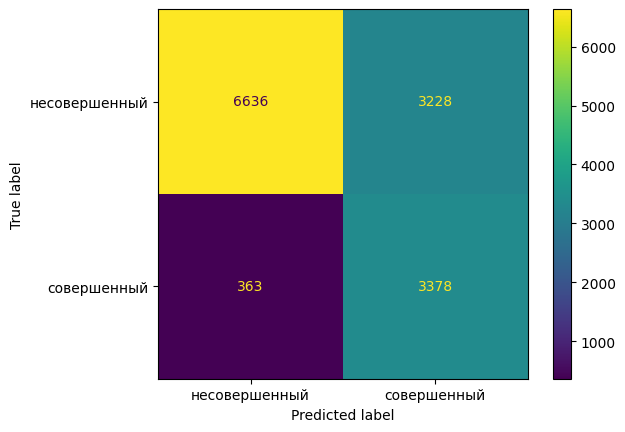

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, test_predictions),
                              display_labels=['несовершенный', 'совершенный'])
disp.plot()

In [ ]:
next(iter(test_dataloader))['input_ids'][0][0]

In [ ]:
def get_texts_with_false_pred(preds=test_predictions,
                              loader=test_dataloader,
                              inx2tok=inx2tok):
  false_neg, false_pos = [], []
  preds = [int(i.item()) for i in preds]

  for inx, obj in enumerate(loader):
    input_ids = [int(i) for i in obj['input_ids'][0]]
    labels = int(obj['labels'][0])

    if labels != preds[inx]:
      if labels == 1 and preds[inx] == 0:
        text = [inx2tok.get(int(i), '') for i in obj['input_ids'][0] if int(i) not in {0, 1, 2, 3}]
        false_neg.append(text)
      elif labels == 0 and preds[inx] == 1:
        text = [inx2tok.get(int(i), '') for i in obj['input_ids'][0] if int(i) not in {0, 1, 2, 3}]
        false_pos.append(text)
  return {
      'false_neg': false_neg,
      'false_pos': false_pos
  }

In [ ]:
# model: imperfective | label: perfective

for i in sorted(get_texts_with_false_pred()['false_neg'][:20], key=len):
  print(*i, end='\n')

год .
тог о как ег о реаним ир ова л л. о. я н :
в сентябр е 1990 год а старт ова л а как солод ов ая я .
17 мардохей пошел и с делал вс е , как велел а ем у эсфирь .
зр я он тогд а , в юн ост и , на ней не жен и л ся .
про дукт ы куп и л не там , гд е дед велел , а на рын к е .
оль , ид и по смотр и , чт о там , по том рас скаж ешь , — велел отец .
и за муж вы ход и л а уж е берем енн ая , а так бы он на ней не жен и л ся .
эт а авантюр ист к а хотел а жен и ть на себ е мо ег о к у ! » — кричал а софь я мирон овн а .
на стольк о добр а , чт о н и словеч ком не возраз и л а , когд а супруг велел а ть как ого - т о юрод ив ого .
средн и е компани и спешат у совершен ств ова ть техн о лог ии ведени я бизнес а и рас шир и ть гео граф и ю де я тельн ост и .
ром а , т ы ид и к шеф у , он велел , чтоб ы т ы с раз у к нем у яв и л ся , как тольк о при дешь .
к с лов у , лео нард из стэн форд ск ого университет а не давн о шок ир ова л коллег проблем ой астр о ном ическ и больш о го числ а реш

In [ ]:
# model: perfective | label: imperfective

for i in sorted(get_texts_with_false_pred()['false_pos'][:20], key=len):
  print(*i, end='\n')

вот ведь в чем за гад к а — по чем у их амнист ир ова л и ?
а по то му , не с делав н и каких по пыт ок дистанц ир ова ть ся от них , тр е губ ец продолж а л :
такж е алексей ир ов по требова л , чтоб ы сня л сво ю кандидат ур у и тем самым аннул ир ова л итог и вы бор ов .
воз род ив греч еск ий и , отказ а вш и сь от об у в и , он а реформ ир ова л а сцен ическ ий костюм .
любознательн ы е по на тур е , он и заимств ова л и достиж ени я ин о странц ев , н о не коп ир ова л и их .
как ов а мер а факт а и мер а вы мысл а в вашей проз е и как трансформ ир ова л ся в ней ваш лич н ый жи зн енн ый опыт ?
по явл ени е акафист а мож н о дат ир ова ть меж д у 1763 и 1795 гг. — скор ее в с е г о , ближ е к по след н ей дат е .
виз ит состо я л ся не с кольк ими не дел я ми ран ее в рам к ах про грамм ы , котор ую вот уж е тр и год а реализуют в гимнази и « гармон и я » .
мим ик а и жест ы реч и реализуют « » в о - зр и тельн ом от нош ени и реч ев ую ин тон аци ю ; в этом от нош ени и он и ка